# Image scaling
### Author: Pawel Budzynski

The following notebook presents the proces of scalling images using FFT and compares the outcomes with other techniques. Subsampling for downscaling and linear interpolation in space domain in case of upscaling.

In [1]:
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.fft
import skimage.io
import skimage.color
import skimage.transform

Load the image and transform it to grayscale. Thanks to that it's only necessary to deal with one matrix instead of repeating all the transformations on separate RGB channels. 

In [2]:
image = skimage.io.imread('barbara.jpg')
print(f"Original shape: {image.shape}")
# Transform tensor to 2D matrix, 
# otherwise need to deal with each color separately
image = skimage.color.rgb2gray(image)
print(f"Grayscale shape: {image.shape}")

Original shape: (512, 512, 3)
Grayscale shape: (512, 512)


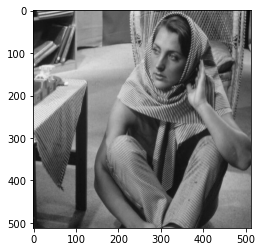

In [3]:
plt.imshow(image, cmap='gray')

Since a representation of the image is 2D matrix it is necessary to apply 2D Fourier transform. Furthermore, the numerical Fourier transform returns complex values with most significant frequencies at the edges. Thus a shift is applied (reordering the matrix) and absolute values are used for the plot. Furthermore, log values are plot since the original values range leads to black square.

In [4]:
image_fft = scipy.fft.fft2(image)
abs_fft = np.abs(image_fft)
print(f"Raw fft values :: max: {np.max(abs_fft)}, min: {np.min(abs_fft)}, mean: {np.mean(abs_fft)}")
log_fft = np.log(abs_fft)
print(f"Log fft values :: max: {np.max(log_fft)}, min: {np.min(log_fft)}, mean: {np.mean(log_fft)}")

Raw fft values :: max: 114381.4274509804, min: 0.0019718281115630393, mean: 28.3432811350102
Log fft values :: max: 11.647293997291595, min: -6.228794191122526, mean: 2.4781025186943766


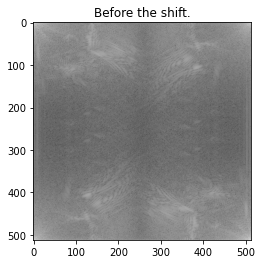

In [5]:
plt.imshow(np.log(np.abs(image_fft)), cmap='gray')
plt.title("Before the shift.")
plt.show()

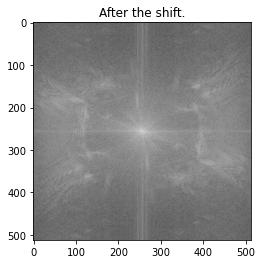

In [6]:
image_fft = scipy.fft.fftshift(image_fft)
plt.imshow(np.log(np.abs(image_fft)), cmap='gray')
plt.title("After the shift.")
plt.show()

# Downsizing images

In this part downsizing of the images is performed. The effect of subsampling is compared to the FFT-based downsizing. 
Keeping in mind the fact that size of the images is going to change a pyramid plot representation is going to be used to present the results. For that helper functions need to be defined. A pyramid is construcred by simply inserting all the images into one array. For proper display, normalization is needed. 

In [7]:
def normalize(img: np.ndarray) -> np.ndarray:
    """Normalize array to 0-1 values."""
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def plot_pyramid(
    images: List[np.ndarray], 
    title: Optional[str] = None,
    size: Tuple[int, int] = (15, 20),
) -> None:
    """Takes an array of images and compose them into a gausian pyramid.
    Requires an array of square images each next half size of previous.
    """
    image = images[0]
    rows, cols = image.shape

    # Create empty array which is a pase for the pyramid: original size + half
    composite_image = np.zeros((rows, cols + cols // 2), dtype=np.double)
    # Insert noramlized original image to the array.
    # Normaliation required as images are merged and may not be displayed properly afterwards.
    composite_image[:rows, :cols] = normalize(image)

    i_row = 0
    for img in images[1:]:
        # Normalize image.
        img =  normalize(img)
        n_rows, n_cols = img.shape
        # Insert image into proper coordinates.
        composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = img
        i_row += n_rows

    fig = plt.figure(figsize=size)
    plt.imshow(composite_image, cmap='gray')
    if title: 
        plt.title(title, fontsize=40)
    plt.show()

In [8]:
def images_to_fft(images: List[np.ndarray]) -> List[np.ndarray]:
    """Takes a list of images and perform 2D FFT and additional transformations
    for the sake of displaying spectral information as a greyscale image.
    """
    # 2D FFT transformation of the image. 
    fft_images = [scipy.fft.fft2(img) for img in images]
    # Reordering the array.
    fft_images = [scipy.fft.fftshift(img) for img in fft_images]
    # Applying logarithm to absolute values.
    fft_images = [np.log(np.abs(img)) for img in fft_images]
    return fft_images

In [9]:
def downsize_image_subs(
    image: np.ndarray, 
    scale: int = 2,
) -> np.ndarray:
    """Downsize given image by subsampling.
    Simply skip every n-th row and column.
    """
    new_img = image.copy()
    new_img = new_img[::scale, ::scale]
    
    return new_img

In [10]:
def downsize_image_fft(
    image: np.ndarray, 
    scale: int = 2,
) -> np.ndarray:
    """Downsize an image by resizing in Fourier domain.
    """
    image_fft = scipy.fft.fft2(image)
    h, w = image.shape
    # Define margin to crop the less significant frequencies from the edges.
    h_margin = int(h - h/scale)
    w_margin = int(w - w/scale)
    # Shift the transformed image so dominant frequencies are in the center.
    image_fft = scipy.fft.fftshift(image_fft)
    # Crop the central part of the transformed image for desired size.
    image_fft = image_fft[h_margin//2:-h_margin//2:, w_margin//2:-w_margin//2:]
    # Revert shift and apply inverse Fourier transformation.
    image_fft = scipy.fft.ifftshift(image_fft)
    new_image = scipy.fft.ifft2(image_fft)
    return np.abs(new_image)

Outcome of subsampling scaling is presented below. Thanks to the pyramid plot it is possible to notice that this way of downsizing leads to visible artifacts in the image. Furthermore, changes in the spectrum could be spoted. This leads to a conclusion that subsampling is a very disruptive technique that leads to change in the information represented. The outcomes of FFT-based downsizing looks way more smooth and similar to the original image, no artifacts are visible. Also the spectrum of the images looks more similar, no significant changes can be noticed as it was not edited, only edge walues were removed.

In [11]:
pyramid_subs = [image] + [downsize_image_subs(image, scale=2**i) for i in range(1, 9)]
pyramid_fft = [image] + [downsize_image_fft(image, scale=2**i) for i in range(1, 9)]

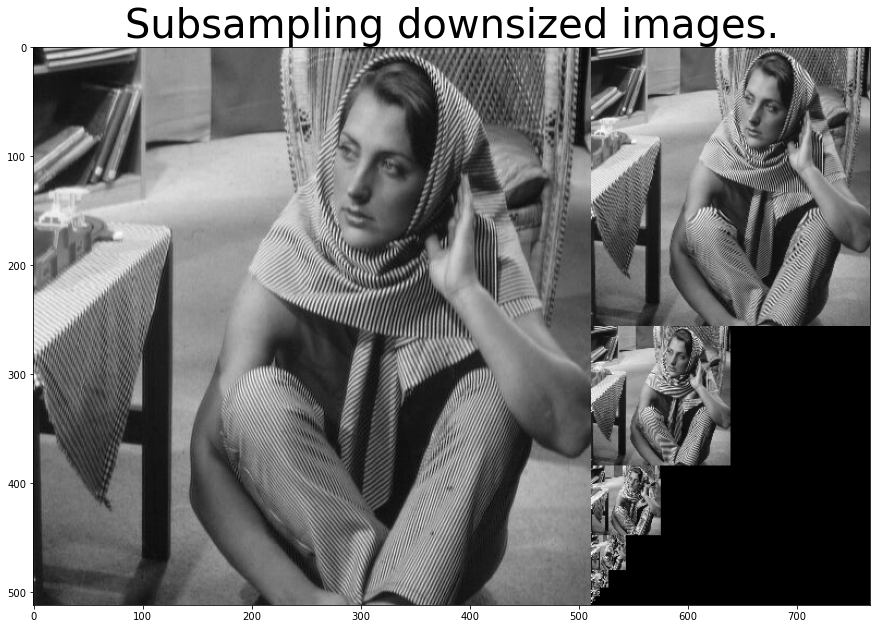

In [12]:
plot_pyramid(pyramid_subs, title="Subsampling downsized images.")

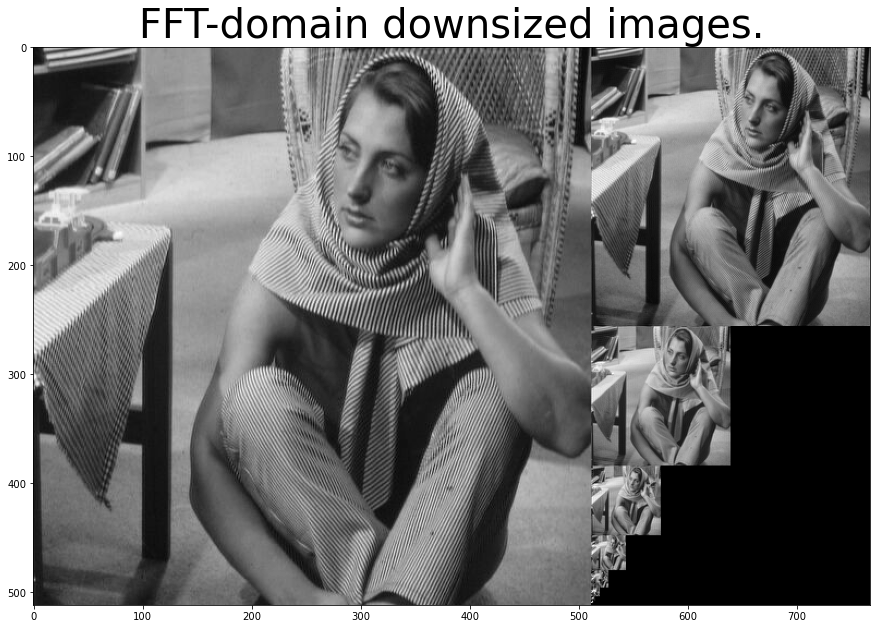

In [13]:
plot_pyramid(pyramid_fft, title="FFT-domain downsized images.")

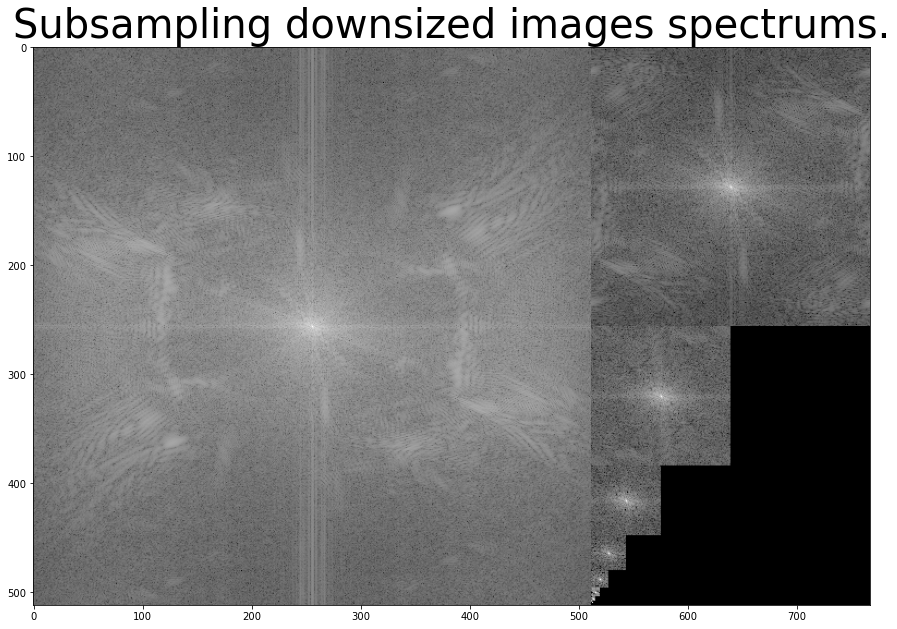

In [14]:
plot_pyramid(images_to_fft(pyramid_subs), title="Subsampling downsized images spectrums.")

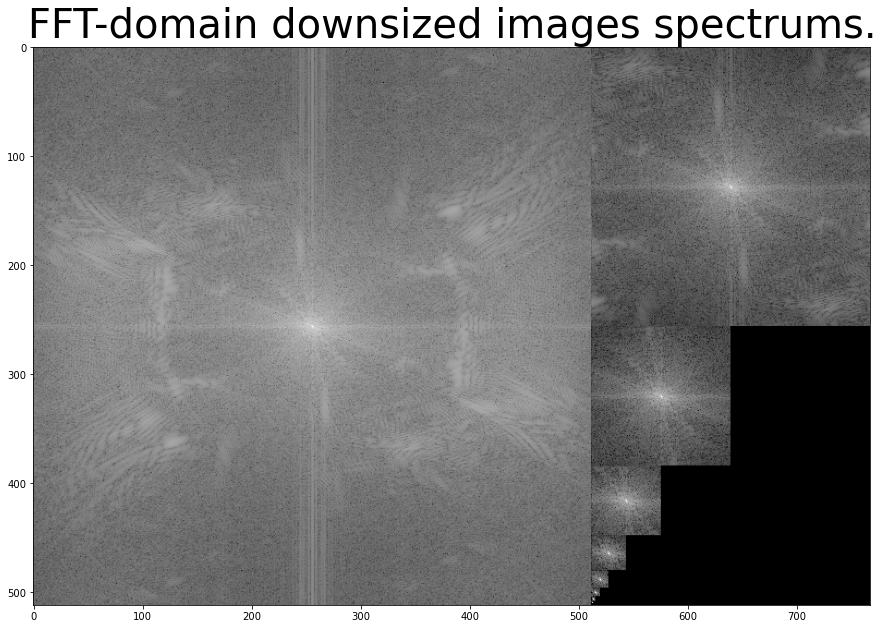

In [15]:
plot_pyramid(images_to_fft(pyramid_fft), title="FFT-domain downsized images spectrums.")

# Upzising images

In [16]:
def upsize_image_interp(
    image: np.ndarray, 
    scale: int = 2,
) -> np.ndarray:
    """Upsize the image using ready to use implementation
    of the interpolation resizing algorithm.
    """
    w, h = image.shape
    return skimage.transform.resize(
        image, output_shape=(w*scale, h*scale), anti_aliasing=False)

In [17]:
def upsize_image_fft(
    image: np.ndarray,
    scale: int = 2,
) -> np.ndarray:
    """Upsize the image by resizing in Fourier domain.
    """
    image_fft = scipy.fft.fft2(image)
    h, w = image.shape
    # Shift the transformed image so dominant frequencies are in the center.
    image_fft = scipy.fft.fftshift(image_fft)
    # Increase the size by adding 0 padding as least dominant frequencies.
    image_fft = np.pad(
        array=image_fft, 
        pad_width=(h*(scale-1))//2, 
        mode='constant',
    )
    # Revert shift and apply inverse Fourier transformation.
    image_fft = scipy.fft.ifftshift(image_fft)
    new_image = scipy.fft.ifft2(image_fft)
    return np.abs(new_image)

In [18]:
# Generate only 3 images as output images are becoming extremely huge.
pyramid_interp = [image] + [upsize_image_interp(image, scale=2**i) for i in range(1, 4)]
pyramid_fft_up = [image] + [upsize_image_fft(image, scale=2**i) for i in range(1, 4)]

# Revert list order as for the pyramid plot the biggest image must be the first one.
pyramid_interp = pyramid_interp[::-1]
pyramid_fft_up = pyramid_fft_up[::-1]

In [ ]:
plot_pyramid(pyramid_interp, title="Interpolation upsized images.", size=(100, 150))

In [ ]:
plot_pyramid(pyramid_fft_up, title="FFT-domain upsized images.", size=(100, 150))

In case of the upsized images the difference is hard to notice although images transformed in FFT-domain appear to be a bit more sharp. For more detailed comparison images should be save to a file and displayed full-screen. 

In [ ]:
plot_pyramid(images_to_fft(pyramid_interp), title="Interpolation upsized images spectrums.")

In [ ]:
plot_pyramid(images_to_fft(pyramid_fft_up), title="FFT-domain upsized images spectrums.")

The changes in images spectrum are more visible. Remembering that the smallest image corresponds to the original image it is visible that the information was changed significantly. In the case of interpolation one can see very strong (closer to white) regions appearing periodically. On the other hand scaling in Fourier domain should create no new information as it was made by simply adding zero values to the original array. However, some artifacts are visible in the new spectrum. There is a chance they are simply the consequence of limited precision of numerical operations performed by the machine.

# Conclusions

- Scaling images in space domain leads to changes in the information.
- Scaling in Fourier domain preserves original information and leads to significanlty better results in case of downsizing. 
- Fourier transform together with inverse transform are a very powerful tools that allow for manipulations in frequency domain.